# Page Detection
This code finds and crops the page out of the image

In [6]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

SMALL_HEIGHT = 800

def implt(img, cmp=None, t=''):
    """Show image using plt."""
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()


def resize(img, height=SMALL_HEIGHT, allways=False):
    """Resize image to given height."""
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height=SMALL_HEIGHT):
    """Getting scale ratio."""
    return img.shape[0] / height

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 9.0)

### Global Variables

In [9]:
IMG = "test.png"    # Image name/number

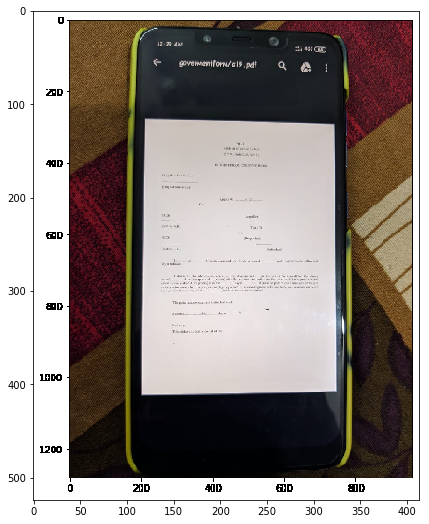

In [10]:
# Loading images and ploting it (converting to RGB from BGR)
image = cv2.cvtColor(cv2.imread("%s" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

In [11]:
def edges_det(img, min_val, max_val):
    """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)

    # Applying blur and threshold
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    implt(img, 'gray', 'Adaptive Threshold')

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    # Contour can't touch side of image
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    implt(img, 'gray', 'Median Blur + Border')

    return cv2.Canny(img, min_val, max_val)

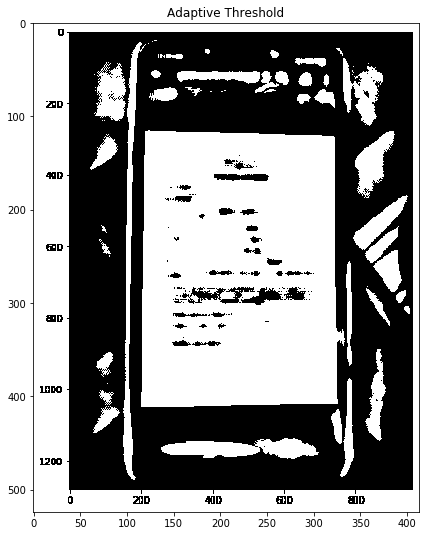

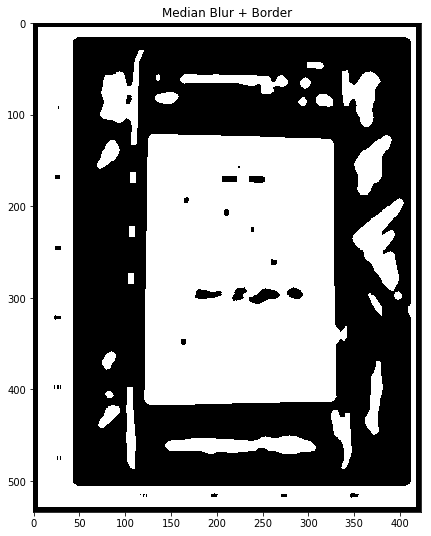

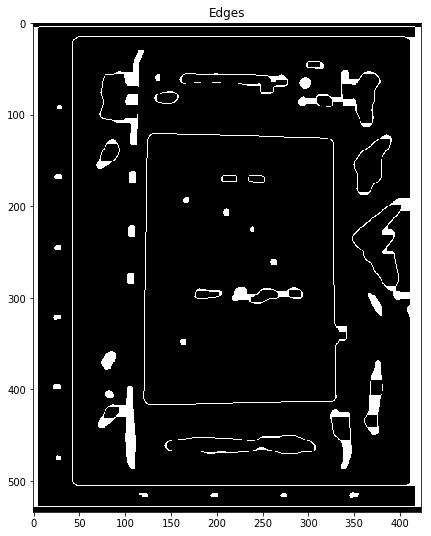

In [12]:
# Edge detection ()
edges_image = edges_det(image, 200, 250)

# Close gaps between edges (double page clouse => rectangle kernel)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
implt(edges_image, 'gray', 'Edges')

In [13]:
def four_corners_sort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contour_offset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def find_page_contours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = four_corners_sort(page_contour)
    return contour_offset(page_contour, (-5, -5))

In [15]:
page_contour = find_page_contours(edges_image, resize(image))
print("PAGE CONTOUR:")
print(page_contour)
implt(cv2.drawContours(resize(image), [page_contour], -1, (0, 255, 0), 3))

       
# Recalculate to original scale
page_contour = page_contour.dot(ratio(image))

ValueError: too many values to unpack (expected 2)

In [16]:
def persp_transform(img, s_points):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = persp_transform(image, page_contour)
implt(newImage, t='Result')
# Saving the result. Yay! (don't forget to convert colors bact to BGR)	
cv2.imwrite("resultImage.jpg", cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB))

NameError: name 'page_contour' is not defined

In [18]:
import numpy as np
import cv2 as cv
img = cv.imread('resultImage.jpg',0)
ret,thresh = cv.threshold(img,127,255,0)
contours,hierarchy = cv.findContours(thresh, 1, 2)

cnt = contours[0]
M = cv.moments(cnt)
print( M )

{'m00': 0.0, 'm10': 0.0, 'm01': 0.0, 'm20': 0.0, 'm11': 0.0, 'm02': 0.0, 'm30': 0.0, 'm21': 0.0, 'm12': 0.0, 'm03': 0.0, 'mu20': 0.0, 'mu11': 0.0, 'mu02': 0.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.0, 'nu11': 0.0, 'nu02': 0.0, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}


In [19]:
x,y,w,h = cv.boundingRect(cnt)
cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

array([[149, 150, 149, ..., 150, 150, 150],
       [151, 149, 152, ..., 150, 150, 150],
       [151, 149, 149, ..., 150, 150, 150],
       ...,
       [151, 150, 150, ..., 226, 225, 225],
       [151, 150, 150, ..., 226, 225, 225],
       [151, 150, 150, ..., 226, 225, 225]], dtype=uint8)

In [20]:
print(w,h)

1 1


In [21]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edges_image, cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None
 
# ensure that at least one contour was found
if len(cnts) > 0:
	# sort the contours according to their size in
	# descending order
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
	# loop over the sorted contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
		# if our approximated contour has four points,
		# then we can assume we have found the paper
		if len(approx) == 4:
			docCnt = approx
			break

NameError: name 'imutils' is not defined

In [2]:
!pip install imutils


In [3]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
 
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="../data/pages/ph.jpg")
args = vars(ap.parse_args())
 
# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

ModuleNotFoundError: No module named 'imutils'

In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2



# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

# load the image, convert it to grayscale, blur it
# slightly, then find edges
image = cv2.imread("test.png")
#print(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

docCnt = None

# ensure that at least one contour was found
if len(cnts) > 0:
	# sort the contours according to their size in
	# descending order
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

	# loop over the sorted contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points,
		# then we can assume we have found the paper
		if len(approx) == 4:
			docCnt = approx
			break

# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
implt(image)
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))
implt(paper)
cv2.imwrite("resultImage.jpg", cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))


ModuleNotFoundError: No module named 'imutils'

In [27]:
import numpy as np
import cv2 as cv
img = cv.imread('resultImage.jpg',0)
ret,thresh = cv.threshold(img,127,255,0)
contours,hierarchy = cv.findContours(thresh, 1, 2)

cnt = contours[0]
M = cv.moments(cnt)
print( M )
x,y,w,h = cv.boundingRect(cnt)
cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
print(h,w)

{'m00': 2.0, 'm10': 86.0, 'm01': 354.0, 'm20': 3698.333333333333, 'm11': 15222.0, 'm02': 62658.33333333333, 'm30': 159057.0, 'm21': 654605.0, 'm12': 2694308.3333333335, 'm03': 11090643.0, 'mu20': 0.33333333333303017, 'mu11': 0.0, 'mu02': 0.3333333333284827, 'mu30': 2.9103830456733704e-11, 'mu21': 5.3660187404602766e-11, 'mu12': 3.637978807091713e-10, 'mu03': 1.862645149230957e-09, 'nu20': 0.08333333333325754, 'nu11': 0.0, 'nu02': 0.08333333333212067, 'nu30': 5.1448789686149945e-12, 'nu21': 9.485870598383896e-12, 'nu12': 6.431098710768743e-11, 'nu03': 3.2927225399135965e-10}
3 3


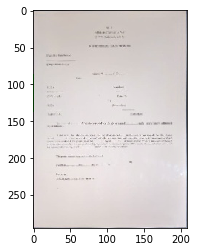

True

In [29]:
import cv2
import numpy as np

img = cv2.imread('resultImage.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
implt(img)
cv2.imwrite('contour.jpg',img)

15


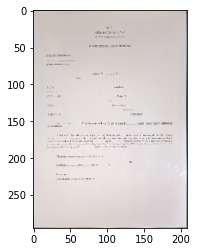

In [63]:
# [load_image]
argv="resultImage.jpg"
    # Check number of arguments
print(len(argv))
if len(argv) < 1:
    print ('Not enough parameters')
    print ('Usage:\nmorph_lines_detection.py < path_to_image >')
    
 # Load the image
src = cv.imread(argv, cv.IMREAD_COLOR)
 # Check if image is loaded fine
if src is None:
    print ('Error opening image: ' + argv[0])
# Show source image
plt.imshow(src)
 # [load_image]
    # [gray]
    # Transform source image to gray if it is not already    
 

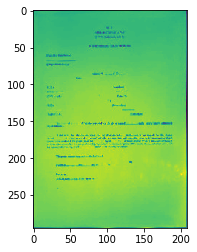

In [64]:

if len(src.shape) != 2:
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
else:
    gray = src
    # Show gray image
plt.imshow(gray)
   

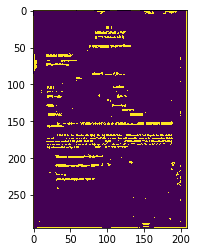

In [65]:
 # [gray]
    # [bin]
    # Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv.bitwise_not(gray)
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                                cv.THRESH_BINARY, 15, -2)
    # Show binary image
plt.imshow(bw)
    

Number of lines: 1


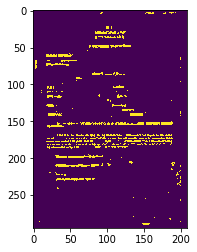

In [66]:
ret, thresh = cv2.threshold(bw, 80, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('Number of lines:', len(contours))
img = cv2.drawContours(bw, contours, -1, (0,255,0), 3)
plt.imshow(img)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


True

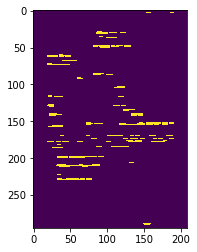

In [69]:
# [bin]
    # [init]
    # Create the images that will use to extract the horizontal and vertical lines
horizontal = np.copy(bw)

#plt.imshow(horizontal)

vertical = np.copy(bw)
    # [init]
    # [horiz]
    # Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 30
    # Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
horizontal = cv.erode(horizontal, horizontalStructure)

plt.imshow(horizontal)

horizontal = cv.dilate(horizontal, horizontalStructure)
print(horizontal)
plt.imshow(horizontal)
cv2.imwrite('zone.jpg',horizontal)

None


TypeError: object of type 'NoneType' has no len()

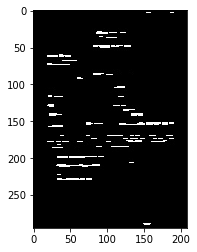

In [70]:
import cv2
import numpy as np
from functools import reduce

def Average(lst): 
    return reduce(lambda a, b: a + b, lst) / len(lst) 

img = cv2.imread('.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 10
maxLineGap = 0
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)

print(lines)
x1list=[]
x2list=[]
diff=[]
for i in range(0,len(lines)):
    for x1,y1,x2,y2 in lines[i]:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
        x1list.append(x1)
        x2list.append(x2)
        diff.append(x2-x1)
plt.imshow(img)
avg=Average(diff)
print(avg)
print(diff)
countdiff=[]
diffindiff=[]
for x in diff:
    countdiff.append(diff.count(x))
    
for x in range(len(diff)-1):
    diffindiff.append(abs(diff[x+1]-diff[x]))

diffindiff.sort()
    
print(diffindiff)
cv2.imwrite('houghlines5.jpg',img)
count=0
for x in countdiff:
    if x>2:
        count=count+1
if count>0:
    print("Above image is of a form")
elif min(diffindiff)<10:
    print("Above image is of a form")
else:
    print("Not a form")